In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse
# import testing_2 as tst

## Importo Ti de las ZT base y con imputaciones (base y ann)

In [4]:
# pbscom
# n2str
# n1au404
sim_base=pd.read_csv('simulation_data/base_EPW.csv',index_col=0,parse_dates=True)
sim_ann_imp_14Nov=pd.read_csv('simulation_data/cnn_14Nov.csv',index_col=0,parse_dates=True)
sim_ann_imp_15Nov=pd.read_csv('simulation_data/cnn_15Nov.csv',index_col=0,parse_dates=True)


In [5]:
dias=['2018-01-30 07:20:00',
 '2018-03-08 07:00:00',
 '2018-06-15 06:10:00',
 '2018-06-27 06:10:00',
 '2018-07-09 06:10:00',
 '2018-08-12 06:30:00',
 '2018-11-14 06:50:00',
 '2018-11-15 06:50:00']

In [9]:
def actualizar_bitacora(infodf,cols_gen,path,nombre_archivo): #adds a new row on a predetermined dataframe 
    df=pd.read_csv(path+nombre_archivo)
    infodf=pd.DataFrame(data=infodf,columns=cols_gen)
    newdf=pd.concat([df,infodf])
    newdf=newdf.set_index('Maximum error')
    newdf.to_csv(path+nombre_archivo)
    return(pd.read_csv((path+nombre_archivo)))


In [7]:
def simulation_metrics(df_base,df2,dias,dia,tolerance,zt):
        df_inic=pd.DataFrame(np.abs(df_base[zt]-df2[zt]))
        df_rolled=df_inic.loc[parse(dias[dia])+pd.Timedelta('8H'):parse(dias[dia])+pd.Timedelta('100D')]
        df_rolled=df_inic.loc[parse(dias[dia])+pd.Timedelta('8H'):parse(dias[dia])+pd.Timedelta('100D')].rolling(6*4,center=True).mean()
        df_rolled.loc[df_rolled[zt]<tolerance,'vanish_day']=True #Gets the time in which the mean difference of the hour is less than the tolerance
        df_end=df_rolled[df_rolled.vanish_day.isnull()==False] #Obtains the first time the conditional from above is true
        df_diff=df_inic.loc[parse(dias[dia])+pd.Timedelta('50Min'):parse(dias[dia])+pd.Timedelta('100D')].rolling(6*5,center=True).mean().diff()
        i=0
        while(True):
            i=i+1
            df_end_index=str(df_end.index[i])
            if df_diff[zt].loc[df_end_index]<0:
                break
        vanish_time=pd.Timedelta(df_end.index[i]-parse(dias[dia]))
        print('vanish_time:',vanish_time)
        max_index_error=parse(str(df_inic[zt].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)].idxmax()))
        max_error=df_inic[zt].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)].max()
        max_time=pd.Timedelta(max_index_error-parse(dias[dia]))
        down_time=df_end.index[i]-max_index_error
    #     print('tiempo de maximo error:',max_index_error)
    #     print('tiempo para maximo error:',max_time)
    #     print('tiempo de bajada:',down_time)
    #     print('valor maximo de error:',max_error)

        return(vanish_time,max_index_error,max_time,down_time,max_error,df_rolled,df_inic,df_diff)

vanish_time: 2 days 07:20:00


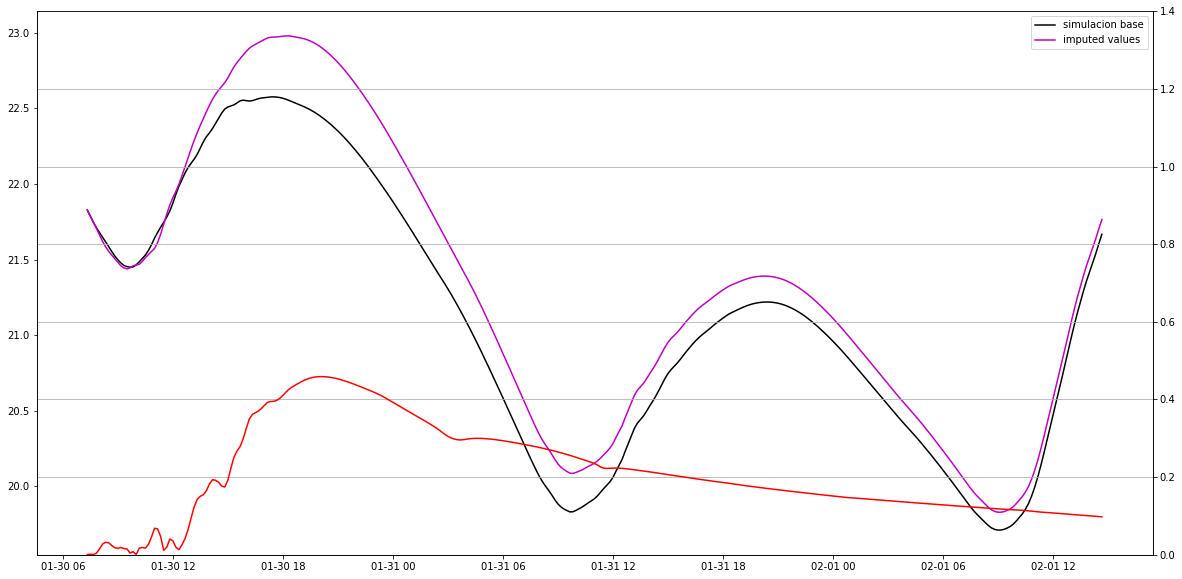

vanish_time: 1 days 15:40:00


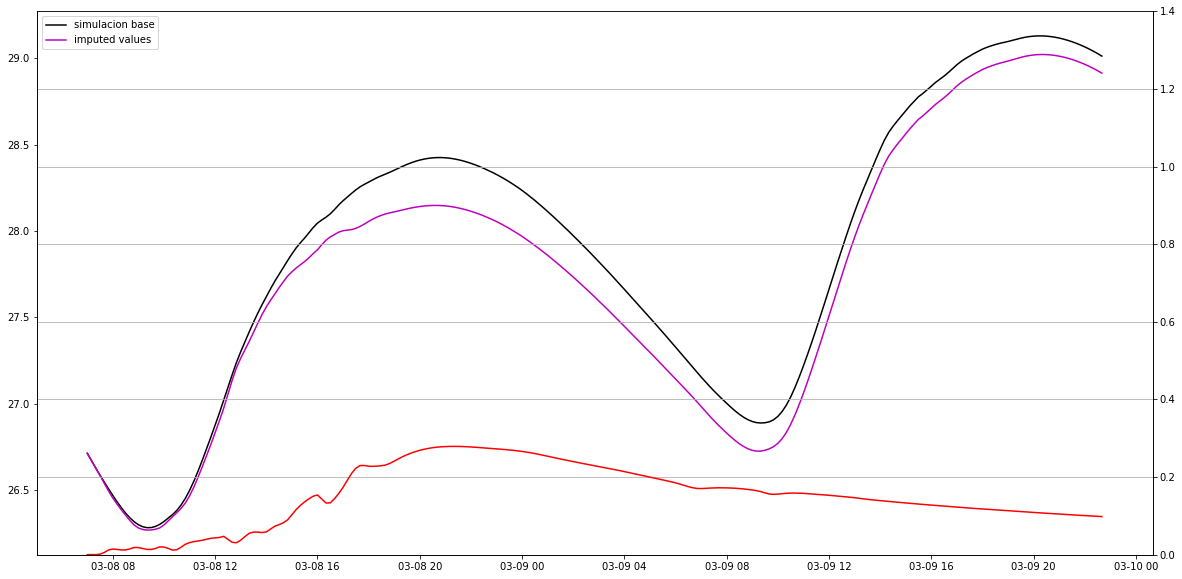

vanish_time: 5 days 03:50:00


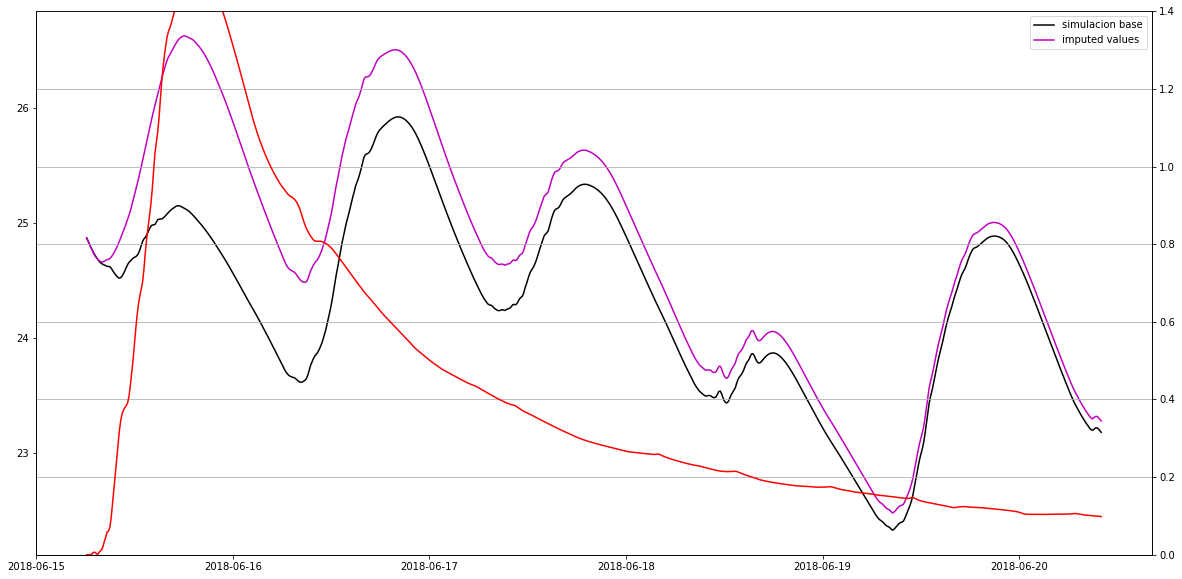

vanish_time: 3 days 02:40:00


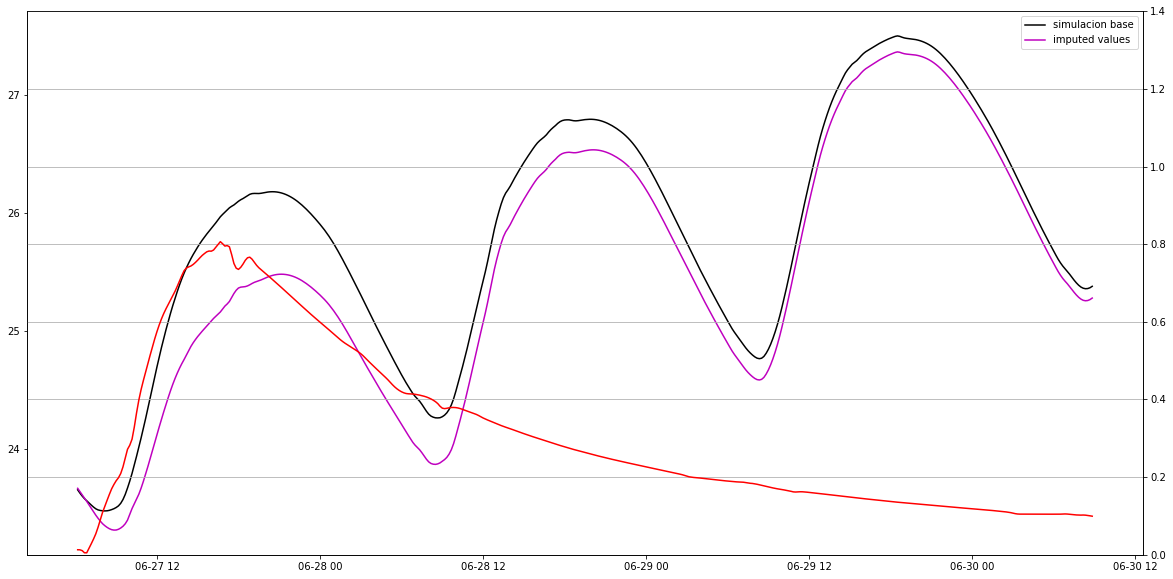

vanish_time: 2 days 19:30:00


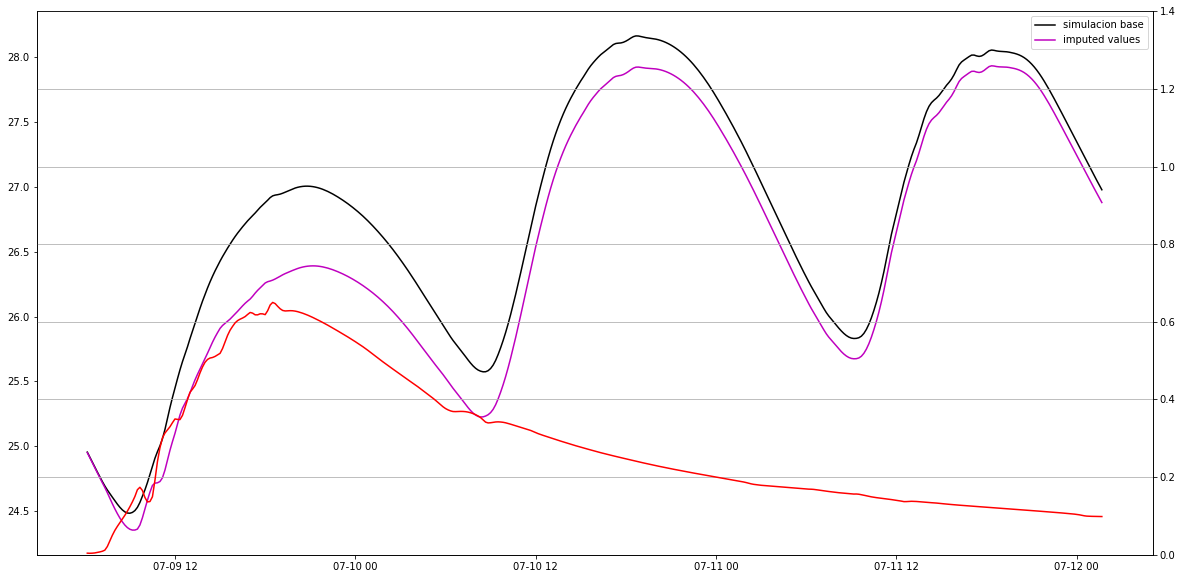

vanish_time: 5 days 02:10:00


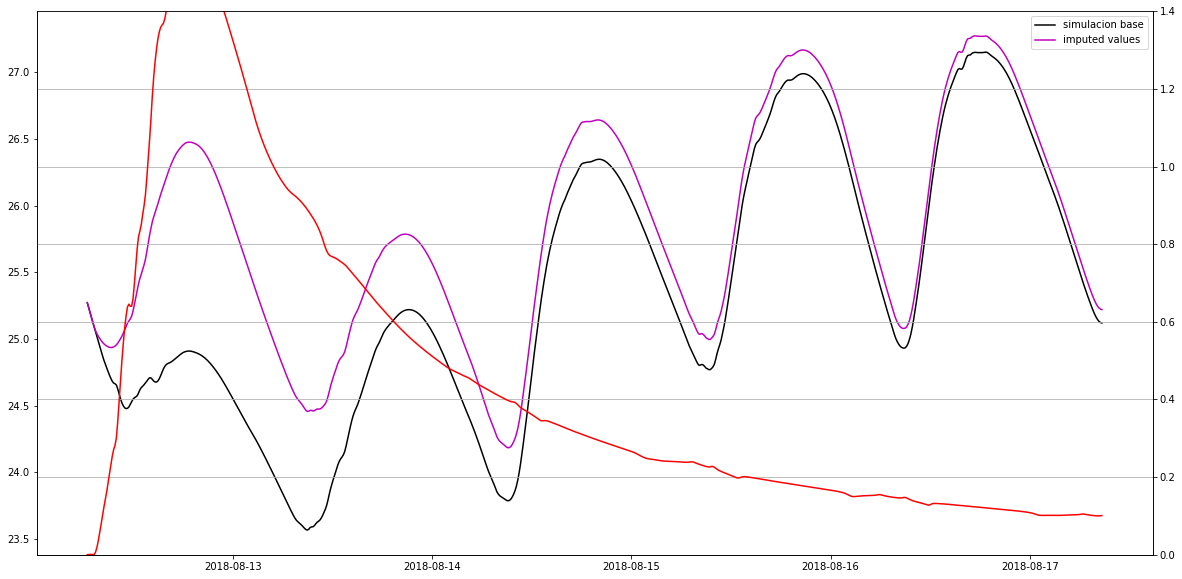

vanish_time: 5 days 06:40:00


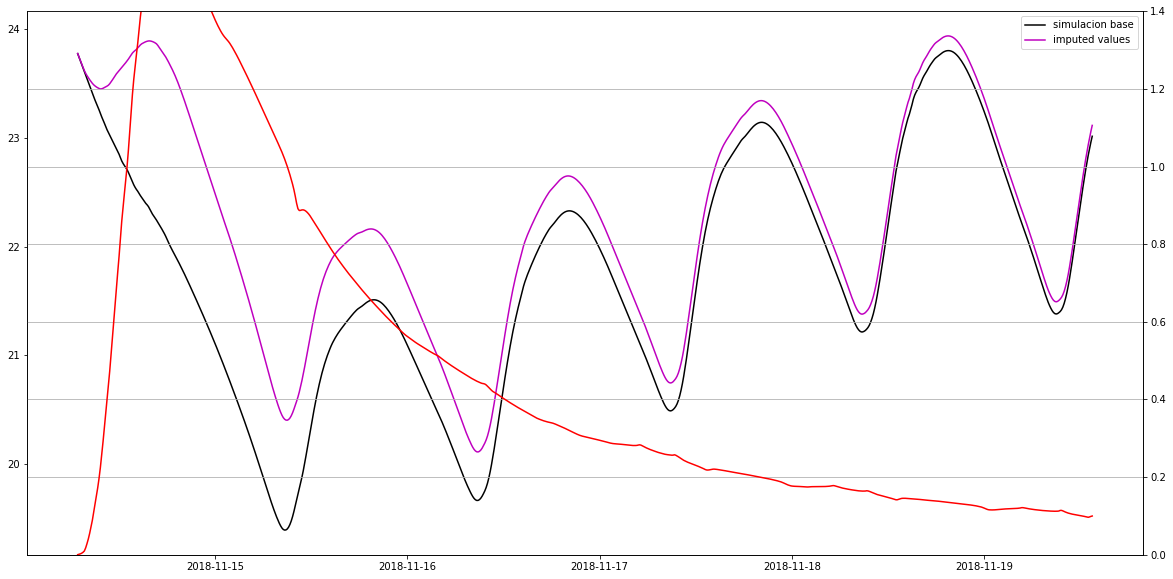

vanish_time: 2 days 13:30:00


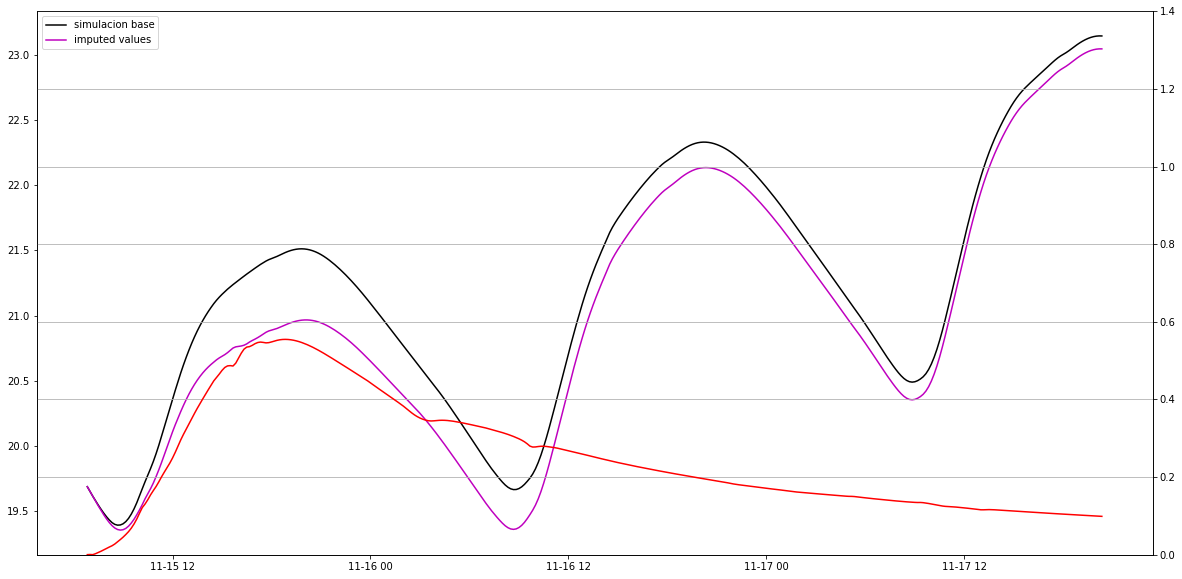

In [30]:
tolerance=.1
thermal_zone='PBSCOM'#'PBSCOM'#'N2STR'
# 'N1AU404'
# 'PBSCOM'
path_metrics='02_simulation_metrics/'
file_metrics='ann_imputation_metrics'+thermal_zone+'.csv'
tz=thermal_zone
sim_imputed=sim_ann_imp_15Nov
save=False
for dia in range(len(dias)):
    if dia==7:
        sim_imputed=sim_ann_imp_14Nov
    vanish_time,max_index_error,max_time,down_time,max_error,df_rolled,df_inic,df_diff=simulation_metrics(
    sim_base,sim_imputed,dias,dia,tolerance,thermal_zone)
    fig, ax=plt.subplots(figsize=(20,10))
    ax.plot(sim_base[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'k-',label='simulacion base')
    ax2=ax.twinx()
    ax.plot(sim_imputed[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'m-',label='imputed values')
    ax2.plot(df_inic[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'r-',label='error')
#     ax2.plot(df_rolled[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'m-',label='error_rolled')
    ax.legend()
    #ax2.legend()
    ax2.set_ylim(0,1.4)
    ax2.grid()
    plt.show()
    if save==True:
        if dia==0:
            first=np.array([dias[dia],vanish_time,max_error,max_index_error,max_time,down_time]).reshape(1,6)
            cols=['Date_imputed','vanishing_time','Maximum error','Time of maximum error','Time for maximum error','Time from maximum to tolerated error']
            simulation_met=pd.DataFrame(first,columns=cols)
            simulation_met=simulation_met.set_index('Maximum error')
            simulation_met.to_csv(path_metrics+file_metrics)
        else:
            first=np.array([dias[dia],vanish_time,max_error,max_index_error,max_time,down_time]).reshape(1,6)
            actualizar_bitacora(first,cols,path_metrics,file_metrics)


In [26]:
ann_metrics=pd.read_csv(path_metrics+'ann_imputation_metricsPBSCOM.csv')
ann_metrics

,Maximum error,Date_imputed,vanishing_time,Time of maximum error,Time for maximum error,Time from maximum to tolerated error
0,0.458872,2018-01-30 07:20:00,2 days 07:20:00,2018-01-30 20:10:00,0 days 12:50:00,1 days 18:30:00
1,0.279242,2018-03-08 07:00:00,1 days 15:40:00,2018-03-08 21:20:00,0 days 14:20:00,1 days 01:20:00
2,1.523678,2018-06-15 06:10:00,5 days 03:50:00,2018-06-15 19:30:00,0 days 13:20:00,4 days 14:30:00
3,0.806450,2018-06-27 06:10:00,3 days 02:40:00,2018-06-27 16:40:00,0 days 10:30:00,2 days 16:10:00
4,0.649981,2018-07-09 06:10:00,2 days 19:30:00,2018-07-09 18:30:00,0 days 12:20:00,2 days 07:10:00
5,1.566109,2018-08-12 06:30:00,5 days 02:10:00,2018-08-12 19:00:00,0 days 12:30:00,4 days 13:40:00
6,1.662901,2018-11-14 06:50:00,5 days 06:40:00,2018-11-14 18:30:00,0 days 11:40:00,4 days 19:00:00
7,0.554811,2018-11-15 06:50:00,2 days 13:30:00,2018-11-15 18:50:00,0 days 12:00:00,2 days 01:30:00


In [27]:
ann_metrics=pd.read_csv(path_metrics+'ANN_imputation_metricsN1AU404.csv')
ann_metrics

,Maximum error,Date_imputed,vanishing_time,Time of maximum error,Time for maximum error,Time from maximum to tolerated error
0,0.439573,2018-01-30 07:20:00,4 days 11:10:00,2018-01-30 21:20:00,0 days 14:00:00,3 days 21:10:00
1,0.237565,2018-03-08 07:00:00,2 days 12:10:00,2018-03-08 21:20:00,0 days 14:20:00,1 days 21:50:00
2,1.344752,2018-06-15 06:10:00,8 days 12:50:00,2018-06-15 19:50:00,0 days 13:40:00,7 days 23:10:00
3,0.639932,2018-06-27 06:10:00,5 days 09:40:00,2018-06-27 16:40:00,0 days 10:30:00,4 days 23:10:00
4,0.544935,2018-07-09 06:10:00,5 days 04:10:00,2018-07-09 18:30:00,0 days 12:20:00,4 days 15:50:00
5,1.364701,2018-08-12 06:30:00,8 days 09:50:00,2018-08-12 19:30:00,0 days 13:00:00,7 days 20:50:00
6,1.563570,2018-11-14 06:50:00,8 days 20:40:00,2018-11-14 16:50:00,0 days 10:00:00,8 days 10:40:00
7,0.495156,2018-11-15 06:50:00,4 days 15:00:00,2018-11-15 17:10:00,0 days 10:20:00,4 days 04:40:00


In [12]:
ann_metrics=pd.read_csv(path_metrics+'ANN_imputation_metricsN2STR.csv')
ann_metrics

,Maximum error,Date_imputed,vanishing_time,Time of maximum error,Time for maximum error,Time from maximum to tolerated error
0,0.369597,2018-01-30 07:20:00,4 days 08:50:00,2018-01-30 20:00:00,0 days 12:40:00,3 days 20:10:00
1,0.217848,2018-03-08 07:00:00,2 days 06:20:00,2018-03-08 21:40:00,0 days 14:40:00,1 days 15:40:00
2,1.134428,2018-06-15 06:10:00,8 days 11:50:00,2018-06-15 20:00:00,0 days 13:50:00,7 days 22:00:00
3,0.552436,2018-06-27 06:10:00,5 days 02:20:00,2018-06-27 16:40:00,0 days 10:30:00,4 days 15:50:00
4,0.484494,2018-07-09 06:10:00,4 days 23:40:00,2018-07-09 18:30:00,0 days 12:20:00,4 days 11:20:00
5,1.173333,2018-08-12 06:30:00,8 days 06:20:00,2018-08-12 19:40:00,0 days 13:10:00,7 days 17:10:00
6,1.353847,2018-11-14 06:50:00,8 days 22:10:00,2018-11-14 16:40:00,0 days 09:50:00,8 days 12:20:00
7,0.391903,2018-11-15 06:50:00,4 days 06:30:00,2018-11-15 17:10:00,0 days 10:20:00,3 days 20:10:00
